In [1]:
import numpy as np
import pandas as pd

from data.dataset import StockDataset
from data.macro import Macro
from data.scaler import HybridScaler
from data.split import StratifiedTimeSeriesSplit
from model.arima import grid_search

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = StockDataset('^GSPC')
df = dataset.get_hist(start_date='1950-01-01', end_date='2021-10-23', time_interval='daily')

In [3]:
x = pd.concat(
    [df, 
     dataset.lookback_agg(lookback_len=30), 
     dataset.lookback_agg(lookback_len=60), 
     dataset.lookback_agg(lookback_len=120)],
    axis=1)

y = dataset.get_change_forecast_label(forecast_len=30, is_up=False, method='past_all')

# Create Exogenous Features

In [4]:
macro = Macro(token='wixdGr7AAc9_syvt6cFD')
macro_data = macro.get_macro()

In [5]:
x = x.merge(macro_data, how='left', on='date')
x.apply(lambda x: x.first_valid_index()).max()

'1987-06-10'

In [6]:
TRAIN_START = '1987-06-10'
# TRAIN_START = '1951-01-01'
TEST_START = '2018-01-01'

train_x = x[TRAIN_START:TEST_START]
train_y = y[TRAIN_START:TEST_START]
test_x = x[TEST_START:]
test_y = y[TEST_START:]

split = TimeSeriesSplit(n_splits=10, test_size=120)
# split = StratifiedTimeSeriesSplit(n_splits=10, test_size=120, min_positive_ratio=0.25)

# Build Model

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('model', RandomForestClassifier(n_estimators=100, random_state=1))
])

In [9]:
results = cross_validate(pipeline, train_x, train_y, cv=split, scoring='accuracy')

In [10]:
results['test_score'].mean()

0.7841666666666668

In [11]:
pipeline.fit(train_x, train_y)
pred_y = pipeline.predict(test_x)

confusion_matrix(test_y, pred_y)

array([[279, 358],
       [ 60, 263]])

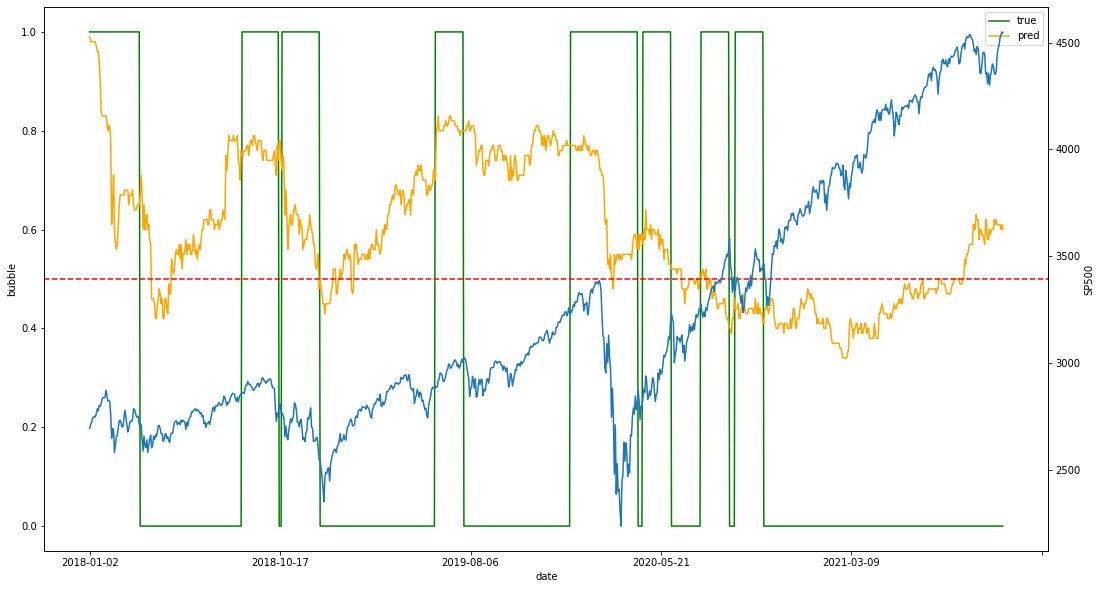

In [12]:
from model.eval import moving_average
import matplotlib.pyplot as plt

# test_df = moving_average(test_y, pipeline.predict_proba(test_x)[:, 1])
test_df = pd.DataFrame({'true': test_y, 'pred': pipeline.predict_proba(test_x)[:, 1]})


ax1 = test_df.plot(figsize=(18, 10), color=['g', 'orange'])
ax1.set_ylabel('bubble')
ax1.axhline(y=0.5, color='r', linestyle='--')

ax2 = ax1.twinx() 
ax2.set_ylabel('SP500')
ax2 = test_x['close'].plot()

# Feature Importance

In [13]:
feature_importances = dict(zip(train_x.columns, pipeline['model'].feature_importances_))

In [14]:
dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

{'past_120_return_std': 0.05555876431810521,
 'past_30_return_std': 0.02948831683870726,
 'past_60_return_std': 0.026742749213423612,
 'gold_lag_Q1': 0.02393551458833794,
 'gold': 0.02126401204402024,
 'past_120_diff_avg': 0.020795444614284647,
 'past_120_return_avg': 0.020164042287608902,
 'past_120_diff_std': 0.020060853836662923,
 'IPI_lag_Q4': 0.019807208539611255,
 'gold_lag_Q2': 0.019447768056514367,
 'IPI_lag_Q3': 0.01745205955452348,
 'past_120_std': 0.017416260709217795,
 'past_120_volume_std': 0.01740962976153383,
 'unemployment_rate': 0.016706526442975066,
 'unemployment_rate_lag_Q4': 0.016470391129248543,
 'GDP_lag_Q2': 0.016283732035897412,
 'IPI_lag_Q2': 0.01611200693277282,
 'gold_lag_Q4': 0.016005749500838284,
 'past_60_diff_std': 0.014352726123065691,
 'unemployment_rate_lag_Q2': 0.014291180161961648,
 'past_60_diff_avg': 0.014219210798153623,
 'GDP_lag_Q3': 0.014201688558123229,
 'past_60_volume_avg': 0.014198688351835718,
 'unemployment_rate_lag_Q3': 0.01399120840255

In [15]:
top_features = list(dict(sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)).keys())[:20]